# Usage

In [1]:
from hydrodata import Station
import hydrodata.datasets as hds
from hydrodata import plot

## Station

`Station` provides some information for a USGS station based on ID or coordinates (longitude and latitude). It requires at least three parameters: start date, end date and a USGS station ID or coordinates. Let's consider the following USGS station:

In [2]:
station_id = '01031500'
start, end = '2000-01-01', '2010-01-21'

Upon instantiation, the station and its watershed characteristics are found using [NLDI](https://labs.waterdata.usgs.gov/about-nldi/) and [USGS Site Information](https://waterdata.usgs.gov/nwis/si) services.

In [3]:
wshed = Station(start, end, station_id=station_id, data_dir="examples/data")

[ID: 01031500] Downloading upstream tributaries from NLDI >>> finished.
[ID: 01031500] Downloading upstream main from NLDI >>> finished.
[ID: 01031500] Downloading flowlines by ComIDs from NLDI >>> finished.
[ID: 01031500] Watershed: Piscataquis River near Dover-Foxcroft, Maine
               Coordinates: (-69.315, 45.175)
               Altitude: 109 m above NGVD29
               Drainage area: 774 sqkm.


## Data Retrieval

Using the retrieved information such as the watershed geometry we can then use the `datasets` module to access other databases. For example, we can find the USGS stations upstream (or downstream) of the main river channel (or tributatires) up to a certain distance, say 150 km. Also, all the USGS stations inside the watershed can be found.

In [43]:
wshed.flowlines.columns

Index(['geometry', 'ogc_fid', 'fdate', 'resolution', 'gnis_id', 'gnis_name',
       'lengthkm', 'reachcode', 'flowdir', 'wbareacomi', 'ftype', 'fcode',
       'streamleve', 'streamorde', 'streamcalc', 'fromnode', 'tonode',
       'hydroseq', 'levelpathi', 'pathlength', 'terminalpa', 'arbolatesu',
       'divergence', 'startflag', 'terminalfl', 'dnlevel', 'uplevelpat',
       'uphydroseq', 'dnlevelpat', 'dnminorhyd', 'dndraincou', 'dnhydroseq',
       'frommeas', 'tomeas', 'rtndiv', 'vpuin', 'vpuout', 'areasqkm',
       'totdasqkm', 'divdasqkm', 'hwnodesqkm', 'maxelevraw', 'minelevraw',
       'maxelevsmo', 'minelevsmo', 'slope', 'elevfixed', 'hwtype',
       'slopelenkm', 'q0001a', 'v0001a', 'qincr0001a', 'q0001b', 'v0001b',
       'qincr0001b', 'q0001c', 'v0001c', 'qincr0001c', 'q0001d', 'v0001d',
       'qincr0001d', 'q0001e', 'v0001e', 'qincr0001e', 'q0001f', 'qincr0001f',
       'arq0001nav', 'temp0001', 'ppt0001', 'pet0001', 'qloss0001',
       'qg0001adj', 'qg0001nav', 'lat', 'ga

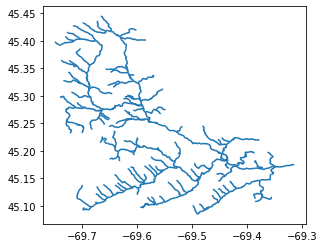

In [56]:
wshed.flowlines[wshed.flowlines.hwtype != 'H'].geometry.plot()

[ID: 01031500] Downloading all the stations upstream tributaries from NLDI >>> finsihed.
[ID: 01031500] Downloading stations within 150 km of upstream main from NLDI >>> finsihed.


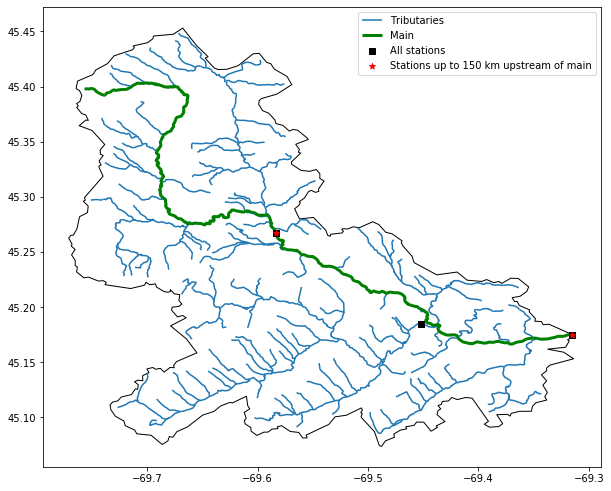

In [5]:
stations = wshed.watershed.get_stations()
stations_upto_150 = wshed.watershed.get_stations(navigation="upstreamMain", distance=150)

ax = wshed.watershed.basin.plot(color='white', edgecolor='black', zorder=1, figsize = (10, 10))
wshed.tributaries.plot(ax=ax, label='Tributaries', zorder=2)
wshed.main_channel.plot(ax=ax, color='green', lw=3, label='Main', zorder=3)
stations.plot(ax=ax, color='black', label='All stations', marker='s', zorder=4)
stations_upto_150.plot(ax=ax, color='red', label='Stations up to 150 km upstream of main', marker='*', zorder=5)
ax.legend(loc='best');

Next, let's get the Digital Elevation Model of the watershed from [OpenTopography](https://opentopography.org/) service.

[CNT: (-69.58, 45.24)] Downloading DEM data from OpenTopography >>> finished.


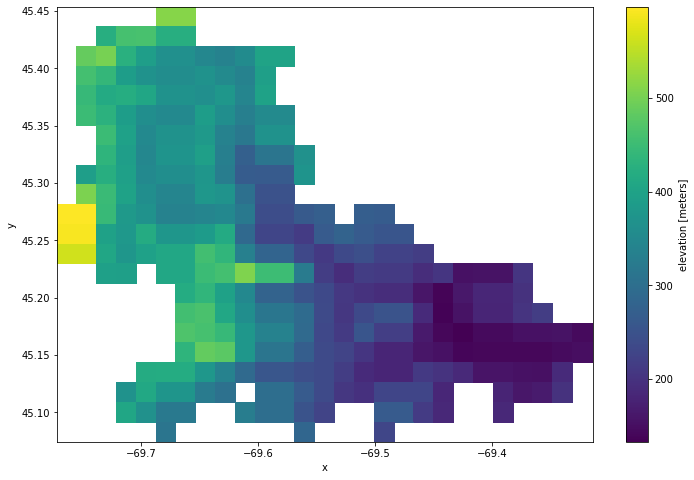

In [6]:
dem = hds.dem_bygeom(wshed.geometry, resolution=60.0/3600.0)
dem.plot(size=8);

The climate and streamflow observations data can be retrieved for the location of interest:

In [9]:
clm = hds.deymet_byloc(wshed.lon, wshed.lat, start=wshed.start, end=wshed.end)
clm['Q (cms)'] = hds.nwis(wshed.station_id, wshed.start, wshed.end)
clm.head()

[LOC: (-69.31, 45.17)] Downloading climate data from Daymet >>> finished.
[ID: 01031500] Downloading stream flow data from NWIS >>> finished.


,dayl (s),prcp (mm/day),srad (W/m^2),swe (kg/m^2),tmax (deg c),tmin (deg c),vp (Pa),Q (cms)
2000-01-01,31104.000000,0.0,185.600006,76.0,-6.0,-17.0,160.0,5.974855
2000-01-02,31104.000000,0.0,182.399994,76.0,-0.5,-11.5,240.0,5.606736
2000-01-03,31104.000000,3.0,121.599998,76.0,5.5,-4.0,440.0,5.295250
2000-01-04,31104.000000,6.0,147.199997,72.0,8.5,-4.0,440.0,4.898814
2000-01-05,31449.599609,13.0,128.000000,88.0,3.0,-6.5,360.0,5.097032


In addition to point-based data, gridded data can also be accessed. For example, let's get the climate data for the whole watershed. The `daymet_bygeom` function can also compute Potential EvapoTranspiration based on FAO-56.

In [11]:
import numpy as np

In [37]:
float(dem.x[0])

-69.76360596706358

In [15]:
np.arange(dem.x.values[0], dem.x.values[-1], 0.01)

array([-69.76360597, -69.75360597, -69.74360597, -69.73360597,
       -69.72360597, -69.71360597, -69.70360597, -69.69360597,
       -69.68360597, -69.67360597, -69.66360597, -69.65360597,
       -69.64360597, -69.63360597, -69.62360597, -69.61360597,
       -69.60360597, -69.59360597, -69.58360597, -69.57360597,
       -69.56360597, -69.55360597, -69.54360597, -69.53360597,
       -69.52360597, -69.51360597, -69.50360597, -69.49360597,
       -69.48360597, -69.47360597, -69.46360597, -69.45360597,
       -69.44360597, -69.43360597, -69.42360597, -69.41360597,
       -69.40360597, -69.39360597, -69.38360597, -69.37360597,
       -69.36360597, -69.35360597, -69.34360597, -69.33360597,
       -69.32360597])

In [10]:
variables = ["tmin", "tmax", "prcp"]
grd = hds.daymet_bygeom(wshed.geometry, start='2005-01-01', end='2005-01-31',
                        variables=variables, pet=True, resolution=60.0/3600.0)

[CNT: (-69.58, 45.24)] Downloading climate data from Daymet >>> finished.
[CNT: (-69.58, 45.24)] Computing PET >>> finished.


TypeError: object of type <class 'float'> cannot be safely interpreted as an integer.

The data is returned as an `xarray` dataset which provides access to some useful exploratory features. It's noteworthy that Daymet data [projection system](https://daymet.ornl.gov/overview) is Lambert Conformal Conic. Thus for plotting purposes it should be considered. For example, we can plot the minimum temperature on 2005/01/02 in Equirectangular projection system as follows:

In [ ]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

lcc = ccrs.LambertConformal(standard_parallels=(25.0, 60.0), central_longitude=-100.0, central_latitude=42.5)
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
cax = fig.add_axes([ax.get_position().x1 + 0.14, ax.get_position().y0, 0.02, ax.get_position().height])
grd.isel(time=1).tmin.plot(ax=ax, transform=lcc, cbar_kwargs={"cax":cax});

Access to actual EvapoTranspiration data through [SSEBop](https://earlywarning.usgs.gov/ssebop/modis/daily) is also possible. However, since there's still no web service available for subsetting the data, `ssebopeta_bygeom` first downloads the data for the requested period then subsets the data based on the provided geometry locally. Therefore, it's not as fast as other functions and the bottleneck is download speed which could vary depending on the available internet speed.

In [ ]:
eta = hds.ssebopeta_bygeom(wshed.geometry, start='2005-01-01', end='2005-01-31',
                           resolution=60.0/3600.0)
eta.isel(time=4).plot(size=8);

Another database that is accessible is land use, land cover data though Multi-Resolution Land Characteristics (MRLC) Consortium. By default the data are downloaded from NLCD 2016.

In [ ]:
lulc, stats = hds.NLCD(wshed.geometry,
                       years={'impervious': 2011, 'cover': 2011, 'canopy': 2011},
                       data_dir=f"examples/data/{wshed.station_id}", statistics=True,
                       resolution=60.0/3600.0)

In addition to storing the retrieved raster files, some statistics on the data is performed and the result is returned as a dictionary. For example, let's get the percentages of each cover category.

In [ ]:
stats['cover']['categories']

The downloaded raster files can be plotted using [rasterio](https://rasterio.readthedocs.io/en/latest/). Hydrodata also provides a helper function for getting the official [legends](https://www.mrlc.gov/data/legends/national-land-cover-database-2016-nlcd2016-legend) of the land cover dataset.

In [ ]:
import numpy as np

cmap, norm = plot.cover_legends()
levels = np.append(norm.boundaries, 100)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 7), dpi=300)
lulc.canopy.plot(ax=ax1, cmap='Greens')
lulc.cover.plot(ax=ax2, cmap=cmap, levels=levels[:-1], cbar_kwargs={"ticks": levels[:-1]})
lulc.impervious.plot(ax=ax3);

Moreover, longitude and latitude coordinates can be used for downloading the data. The coordinates doesn't have to be exact since the closest station within a 50-km radius to the specified coordinates is found automatically.

In [ ]:
lon, lat = -75.097, 40.016
frankford = Station(start, end, coords=(lon, lat), data_dir="examples/data")
frankford_Q = hds.nwis(frankford.station_id, frankford.start, frankford.end)

## Plotting

The hydrologic signatures can be plotted easily using the `signatures` function from the `plot` module. This functions convert the streamflow data from cubic meter per second to millimeter per day based on the watershed area which should be provided in km$^2$.

In [ ]:
plot.signatures({'Piscataquis': ( clm['Q (cms)'], wsheddrainage_area)},
                prcp= clm['prcp (mm/day)'],
                title=wshedname)

We can also plot the data for several stations.

In [ ]:
Q_daily = {'Piscataquis': ( clm['Q (cms)'], wsheddrainage_area),
           'Frankford': (frankford_Q, frankford.drainage_area)}
plot.signatures(Q_daily=Q_daily,
                title='Streamflow data for two watersheds')